In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf


In [ ]:
!pip3 install yfinance
import yfinance as yf

# Loading Data

In [ ]:
def get_stock_data(stock_name,start_date,end_date,normalized=0):
    data = yf.download(stock_name,start_date,end_date)
    df = pd.DataFrame(data)
    df.drop(['Adj Close'],inplace=True,axis=1)
    return df

In [ ]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name,'2013-07-12','2019-07-11',0)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2019-07-03,1118.500000,1127.989990,1114.849976,1122.989990,1007700
2019-07-05,1119.369995,1134.650024,1117.500000,1132.670044,1489700
2019-07-08,1125.869995,1127.209961,1111.760010,1116.790039,1494400
2019-07-09,1110.319946,1127.859985,1107.150024,1124.290039,1473600
2019-07-10,1132.319946,1142.339966,1130.660034,1140.910034,1535500


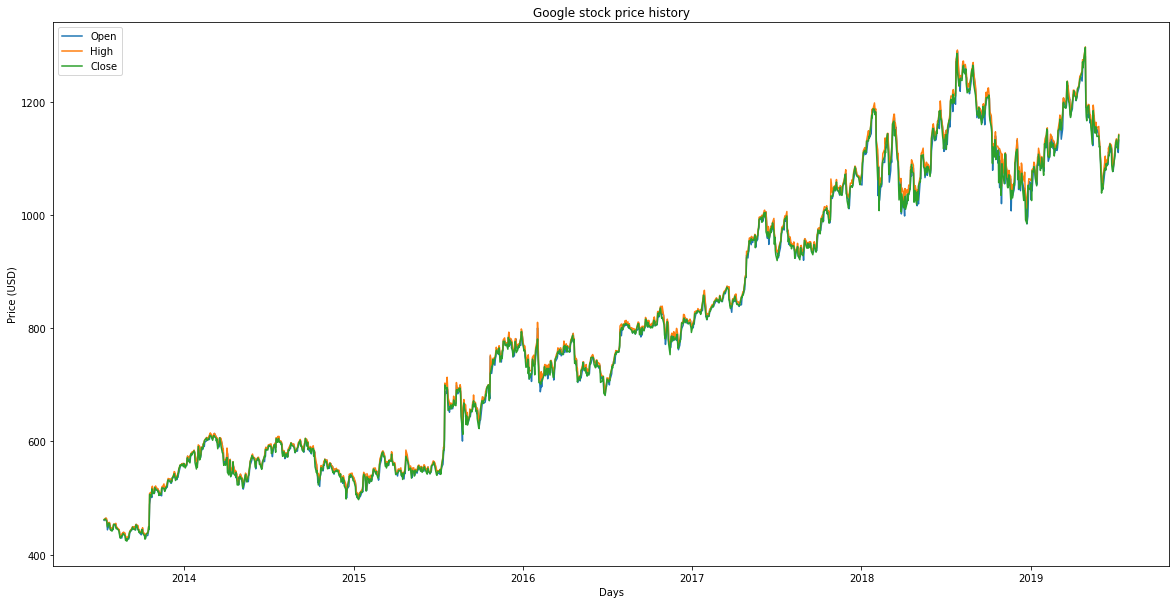

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Close"])
plt.title('Google stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Close'], loc='upper left')
plt.show()

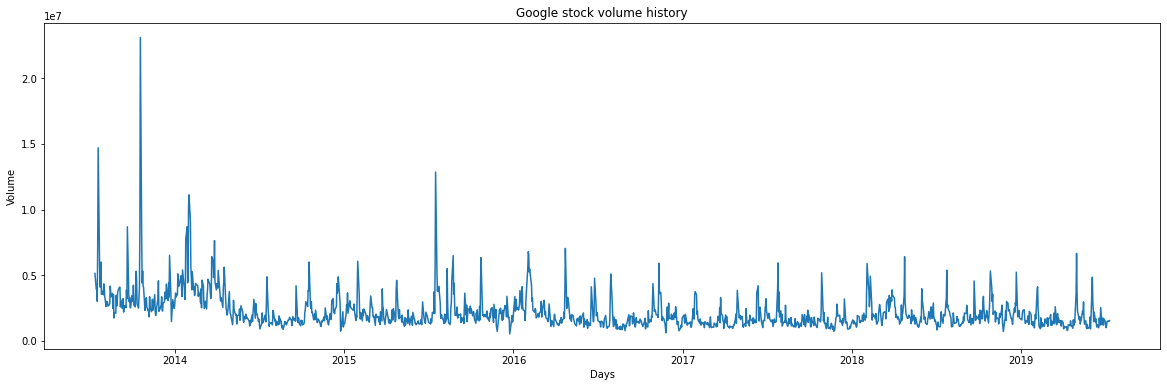

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(df["Volume"])
plt.title('Google stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()
# We can observe that during mid of 2013, their is a clear surge in Volume, maybe due to low price.

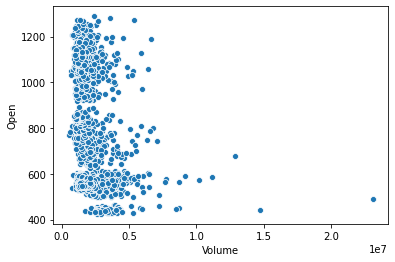

In [ ]:
sns.scatterplot(df['Volume'],df["Open"])
# We can irrespective of price google is a well traded stock

In [ ]:
print("checking if any null values are present\n") 
df.isnull().sum()

checking if any null values are present



Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

# Normalizing the data
    The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. 

In [ ]:
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 1207 302


# Supervised Learning and time series data

    LSTMs consume input in format [ batch_size, time_steps, Features ]; a 3- dimensional array.

    A) Batch Size:
    Used to say how many samples of input do you want the Neural Net to see before updating the weights. So let’s say you have 100 samples (input dataset) and you want to update weights every time your NN has seen an input. In that case batch size would be 1 and total number of batches would be 100.

    As it turns out using very small batch size reduces the speed of training and on the other hand using too big batch size (like whole dataset) reduces the models ability to generalize to different data and it also consumes more memory. 

    B) Time Steps:
    Define how many units back in time you want your network to see. For example if you were working on a character prediction problem where you have a text corpus to train on and you decide to feed your network 6 characters at a time. Then your time step is 6. In our case we will be using 60 as time step i.e. we will look into 2 months of data to predict next days price.

    C) Features:
    Is the number of attributes used to represent each time step. Consider the character prediction example above, and assume that you use a one-hot encoded vector of size 100 to represent each character. Then feature size here is 100.

In our case lets use the time steps to be 4, using 4 days our network can be used to predict the 5th day.

Lets use the batch size to be 2, in order to update the weights accordingly.

Features we are using as input are ["Open" ,"High" ,"Low" ,"Close" ,"Volume"], so output will also be the same features using a particular batch size to update the weights and we use 4 day's are input to predict the 5th day's close price.


# Data Preparation

In [ ]:
from tqdm import tqdm_notebook
def build_timeseries(mat, y_col_index,TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [ ]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [ ]:
# x,y <- build_timeseries(matrix_input,outcolindex(close price),Time_steps(as input))
x_t, y_t = build_timeseries(x_train, 3,2)
BATCH_SIZE = 2
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3,2)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (1205, 2, 5) (1205,)



length of time-series i/o (300, 2, 5) (300,)


# Building Model

In [ ]:
BATCH_SIZE = 2
TIME_STEPS = 2
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

# Hyper-parameter tunning

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
              

Train on 1204 samples, validate on 150 samples
Epoch 1/300
 - 1s - loss: 0.0263 - val_loss: 0.0151
Epoch 2/300
 - 1s - loss: 0.0433 - val_loss: 0.0146
Epoch 3/300
 - 1s - loss: 0.0305 - val_loss: 0.0189
Epoch 4/300
 - 1s - loss: 0.0221 - val_loss: 0.0138
Epoch 5/300
 - 1s - loss: 0.0195 - val_loss: 0.0120
Epoch 6/300
 - 1s - loss: 0.0176 - val_loss: 0.0100
Epoch 7/300
 - 1s - loss: 0.0164 - val_loss: 0.0105
Epoch 8/300
 - 1s - loss: 0.0149 - val_loss: 0.0070
Epoch 9/300
 - 1s - loss: 0.0141 - val_loss: 0.0070
Epoch 10/300
 - 1s - loss: 0.0132 - val_loss: 0.0087
Epoch 11/300
 - 1s - loss: 0.0123 - val_loss: 0.0072
Epoch 12/300
 - 1s - loss: 0.0112 - val_loss: 0.0098
Epoch 13/300
 - 1s - loss: 0.0101 - val_loss: 0.0101
Epoch 14/300
 - 1s - loss: 0.0095 - val_loss: 0.0059
Epoch 15/300
 - 1s - loss: 0.0093 - val_loss: 0.0079
Epoch 16/300
 - 1s - loss: 0.0087 - val_loss: 0.0096
Epoch 17/300
 - 1s - loss: 0.0078 - val_loss: 0.0073
Epoch 18/300
 - 1s - loss: 0.0077 - val_loss: 0.0071
Epoch 19

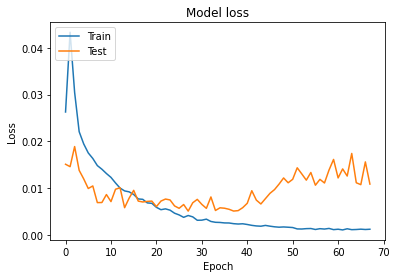

In [ ]:
from matplotlib import pyplot as plt

# Keras fit returns keras.callbacks.history object which stores loss info
history = lstm_model.fit(x_t,y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE, 
              shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE), 
              trim_dataset(y_val, BATCH_SIZE)), callbacks=[es])

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.017045079774846532 (148,) (148,)
[0.80640423 0.81200844 0.81498706 0.8015815  0.7776481  0.7612927
 0.75322443 0.7656258  0.7871081  0.79927903 0.80327845 0.79030335
 0.771607   0.75212175 0.7347151 ]
[0.83620224 0.85664255 0.81539524 0.82403766 0.83512857 0.85094653
 0.85069781 0.82211267 0.78798879 0.81124443 0.8008343  0.78527824
 0.74294408 0.73432795 0.81705826]


In [ ]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])


[1039.7136  1043.9935  1046.2682  1036.0305  1017.7529  1005.2626
  999.10095 1008.57166 1024.9774  1034.2722  1037.3265  1027.4176
 1013.1394   998.2588   984.9656 ]
[1062.4699707  1078.07995605 1046.57995605 1053.18005371 1061.65002441
 1073.72998047 1073.54003906 1051.70996094 1025.65002441 1043.41003418
 1035.45996094 1023.58001709  991.25        984.66998291 1047.84997559]


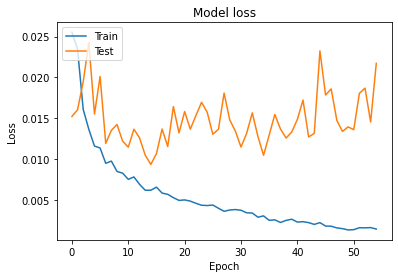

In [ ]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)

Error is 0.017045079774846532 (148,) (148,)


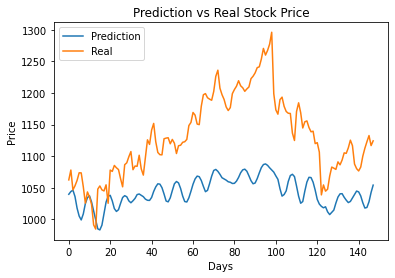

In [ ]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')